In [2]:
import pandas as pd
import numpy as np

x_train, y_train = pd.read_csv("../data/processed/x_train.csv", index_col=0), pd.read_csv("../data/processed/y_train.csv", index_col=0)
x_test, y_test = pd.read_csv("../data/processed/x_test.csv", index_col=0), pd.read_csv("../data/processed/y_test.csv", index_col=0)

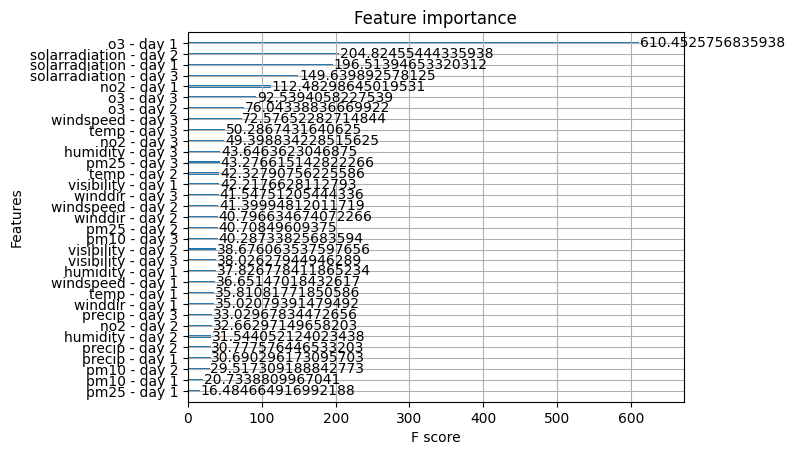

In [71]:
# show importance of features in xtrain based on xgboost feature selector
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot

xbg_reg = xgb.XGBRegressor().fit(x_train, y_train)

plot_importance(xbg_reg, importance_type='gain')
pyplot.show()

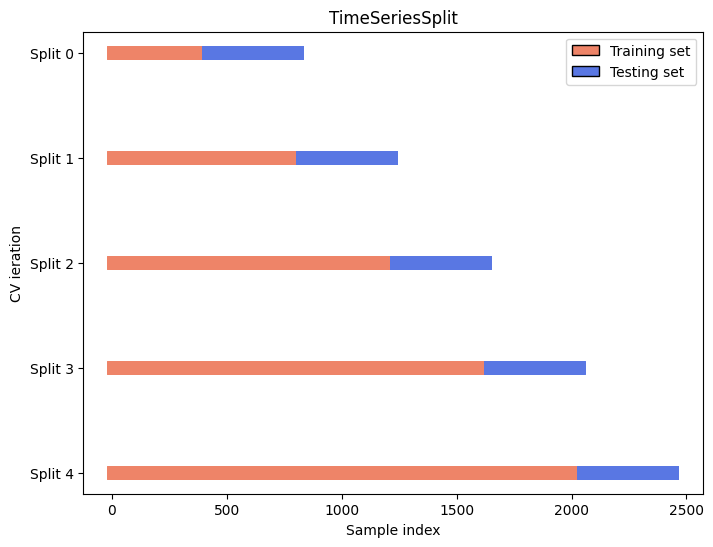

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import TimeSeriesSplit

# Create synthetic data
n_points = len(x_train)
n_splits = 5
X = np.random.randn(n_points, 10)
percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(n_points * perc) for ii, perc in enumerate(percentiles_classes)])

def plot_cv_indices(cv, X, n_splits):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Generate color mapping for training/testing splits
    cmap_data = plt.cm.coolwarm
    for i, (train_index, test_index) in enumerate(cv.split(X)):
        # Train set (blue)
        ax.scatter(train_index, [n_splits - i - 0.5] * len(train_index), c=[cmap_data(0.8)] * len(train_index), marker='_', lw=10, label='Training set' if i == 0 else "")
        # Test set (red)
        ax.scatter(test_index, [n_splits - i - 0.5] * len(test_index), c=[cmap_data(0.1)] * len(test_index), marker='_', lw=10, label='Testing set' if i == 0 else "")

    y_ticks = np.arange(n_splits) + 0.5
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'Split {n_splits - i - 1}' for i in range(n_splits)]) 
    ax.set_xlabel('Sample index')
    ax.set_ylabel('CV ieration')

    legend_elements = [Patch(facecolor=cmap_data(0.8), edgecolor='k', label='Training set'),
                       Patch(facecolor=cmap_data(0.1), edgecolor='k', label='Testing set')]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.title('TimeSeriesSplit')
    plt.show()

# Create the TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=n_splits)

# Plot the TimeSeriesSplit
plot_cv_indices(cv, X, n_splits)


In [3]:
# Importing necessary libraries
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit

# Define the regressor
regressor = DecisionTreeRegressor()

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=False)

# Set up time series split
tss = TimeSeriesSplit(n_splits=5)


# Define the parameter space for Bayesian search
param_space = {
    'max_depth': (5, 30),  # Integer values between 3 and 20
    'min_samples_split': (2, 30),  # Integer values between 2 and 20
    'min_samples_leaf': (1, 30),  # Integer values between 1 and 20
    'max_features': ['sqrt', 'log2', None]  # Categorical choices
}

# Set up BayesSearchCV for hyperparameter optimization
bayes_search = BayesSearchCV(
    estimator=regressor,
    search_spaces=param_space,
    n_iter=50,  # Number of iterations for the search
    cv=tss,  # Cross-validation scheme
    scoring='neg_mean_squared_error',  # Metric for scoring
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,  # To display progress
    random_state=42  # Ensures reproducibility
)

# Perform Bayesian search
bayes_search.fit(x_train, y_train)

# Get the best estimator (regressor with the best hyperparameters)
best_regressor = bayes_search.best_estimator_

# Evaluate the best model
val_mse = mean_squared_error(y_test, best_regressor.predict(x_test))

# Output results
print("Best hyperparameters found by Bayesian optimization:", bayes_search.best_params_)
print("Validation MSE:", val_mse)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [7]:
import xgboost as xgb

xg_regressor = xgb.XGBRegressor()

# Set up time series split
tss = TimeSeriesSplit(n_splits=5)

param_space = {
    'max_depth': (3, 15),  # Limits the depth of each tree, typical values for structured data
    'learning_rate': (0.01, 0.3),  # Controls how much the model learns at each boosting step
    'n_estimators': (50, 500),  # Number of trees (boosting rounds)
    'subsample': (0.5, 1.0),  # Fraction of samples used per tree, prevents overfitting
    'colsample_bytree': (0.5, 1.0),  # Fraction of features used per tree, helps with feature selection
    'min_child_weight': (1, 10),  # Minimum sum of instance weight in a child, regularizes the model
    'gamma': (0, 10),  # Minimum loss reduction required for further partitioning, helps avoid overfitting
}

# Set up BayesSearchCV for hyperparameter optimization
bayes_search = BayesSearchCV(
    estimator=xg_regressor,
    search_spaces=param_space,
    n_iter=50,  # Number of iterations for the search
    cv=tss,  # Cross-validation scheme
    scoring='neg_mean_squared_error',  # Metric for scoring
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,  # To display progress
    random_state=42  # Ensures reproducibility
)

# Perform Bayesian search
bayes_search.fit(x_train, y_train)

# Get the best estimator (regressor with the best hyperparameters)
best_regressor = bayes_search.best_estimator_

# Evaluate the best model on the validation set
y_val_pred = best_regressor.predict(x_test)
val_mse = mean_squared_error(y_test, y_val_pred)

# Output results
print("Best hyperparameters found by Bayesian optimization:", bayes_search.best_params_)
print("Validation MSE:", val_mse)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\chris\coding\air-quality-forecast\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [39]:
pd.DataFrame(y_val_pred)

,0,1,2,3,4,5
0,4.715328,30.613139,4.788321,32.390511,4.905109,32.857664
1,6.206767,29.304511,6.315789,29.142857,6.462406,29.180451
2,4.715328,30.613139,4.788321,32.390511,4.905109,32.857664
3,4.715328,30.613139,4.788321,32.390511,4.905109,32.857664
4,3.956522,32.318841,4.478261,37.681159,4.246377,36.536232
...,...,...,...,...,...,...
521,9.373188,17.815217,10.119565,16.894928,10.369565,16.112319
522,10.648352,12.000000,9.967033,13.395604,9.670330,14.263736
523,15.022727,10.056818,13.295455,12.625000,11.784091,14.829545
524,9.373188,17.815217,10.119565,16.894928,10.369565,16.112319


In [40]:
y_val

,no2,o3,no2 + day 1,o3 + day 1,no2 + day 2,o3 + day 2
date,,,,,,
29/07/2015,4.0,25.0,5.0,33.0,5.0,46.0
28/07/2015,3.0,27.0,4.0,25.0,5.0,33.0
27/07/2015,4.0,27.0,3.0,27.0,4.0,25.0
26/07/2015,3.0,27.0,4.0,27.0,3.0,27.0
25/07/2015,4.0,30.0,3.0,27.0,4.0,27.0
...,...,...,...,...,...,...
05/02/2014,7.0,24.0,9.0,17.0,6.0,24.0
04/02/2014,8.0,23.0,7.0,24.0,9.0,17.0
03/02/2014,11.0,8.0,8.0,23.0,7.0,24.0


In [63]:
np.sqrt(46.47046037002528)

6.816924553640393